# Emotion Detection from Text
Prompt classification is a growing area of natural language processing (NLP) that involves automatically identifying the type, category, or intent behind a given text prompt. This task plays a significant role in conversational AI, automated query handling, and content organization. Through prompt classification, systems can effectively categorize user inputs and provide appropriate responses or actions based on the recognized prompt type. This project focuses on building and evaluating models capable of classifying different prompts into predefined categories using textual features and machine learning techniques.

**Course Name:** Machine Learning Lab

**Course Teachers**

*  B.Lalitha Rajeswari

**Team Members**

*   23BQ1A4261 - Harsha Vardhan Reddy E

### - Importing necessary libraries and loading the data

In [23]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Text Libraries
import nltk 
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature Extraction Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split , cross_val_score

# Classifier Model libraries
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import tree
# from sklearn.pipeline import Pipeline

# Performance Matrix libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import joblib
# other
import warnings
warnings.filterwarnings("ignore")

In [2]:
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")

#  Dataset

In [3]:
df = pd.read_csv("expanded_prompts.csv")
df

,prompt,cluster
0,Write a research paper on the role of technolo...,Academic Research
1,Write a research paper on the role of technolo...,Academic Research
2,Write a research paper on the role of technolo...,Academic Research
3,Write a research paper on the role of technolo...,Academic Research
4,Write a research paper on the role of technolo...,Academic Research
...,...,...
2305,How can I effectively manage stress in my dail...,Wellness Information
2306,How can I effectively manage my weight during ...,Wellness Information
2307,How can mindfulness practices improve my menta...,Wellness Information
2308,How can I effectively manage my weight during ...,Wellness Information


In [4]:
print('Dataset size:',df.shape)
print('Columns are:',df.columns)
Y = df['cluster']

Dataset size: (2310, 2)
Columns are: Index(['prompt', 'cluster'], dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   prompt   2310 non-null   object
 1   cluster  2310 non-null   object
dtypes: object(2)
memory usage: 36.2+ KB


### - Data Preprocessing

#### Preprocessing the prompts

In [6]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))


# Preprocessing function
def preprocess_text(text):

    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenizing text
    tokens = nltk.word_tokenize(text)

    # Removing stopwords and applying lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Joining tokens back to string
    processed_text = " ".join(tokens)

    return processed_text

In [7]:
df["processed_prompt"] = df["prompt"].apply(preprocess_text)
df.head()

,prompt,cluster,processed_prompt
0,Write a research paper on the role of technolo...,Academic Research,write research paper role technology modern ed...
1,Write a research paper on the role of technolo...,Academic Research,write research paper role technology modern ed...
2,Write a research paper on the role of technolo...,Academic Research,write research paper role technology modern ed...
3,Write a research paper on the role of technolo...,Academic Research,write research paper role technology modern ed...
4,Write a research paper on the role of technolo...,Academic Research,write research paper role technology modern ed...


#### Encoding the labels

In [8]:
from sklearn.preprocessing import LabelEncoder

le_cluster = LabelEncoder()
le_sub_class = LabelEncoder()

df["cluster_encoded"] = le_cluster.fit_transform(df["cluster"])

#### Feature Extraction

In [9]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=2, max_df=0.9)
X = vectorizer.fit_transform(df["processed_prompt"])

In [10]:
y_cluster = df["cluster_encoded"]
# Save the cluster label encoder for later use in the Streamlit app
joblib.dump(y_cluster, "cluster_encoder.pkl")
print("Cluster encoder saved as 'cluster_encoder.pkl'")


Cluster encoder saved as 'cluster_encoder.pkl'


In [11]:
# Save the vectorizer for later use in the Streamlit app
joblib.dump(vectorizer, "vectorizer.pkl")
print("Vectorizer saved as 'vectorizer.pkl'")

Vectorizer saved as 'vectorizer.pkl'


###  - Modelling

#### Clusters

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_cluster, test_size=0.2, random_state=42)

In [13]:
# Define models
cluster_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),  # Enable probability for confidence scores
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
}

# Store metrics for visualization
model_metrics = {"Model": [], "Accuracy": [], "F1 Score": []}
cv_scores = {"Model": [], "CV Scores": []}
best_model = None
best_acc = 0

# Train and evaluate models
for name, model in cluster_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    model_metrics["Model"].append(name)
    model_metrics["Accuracy"].append(acc)
    model_metrics["F1 Score"].append(f1)
    if acc > best_acc:
        best_acc = acc
        best_model = model
    print(f"{name} - Accuracy: {acc}, F1 Score: {f1}")
    print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")
    
    # Cross-validation scores
    cv = cross_val_score(model, X, y_cluster, cv=5, scoring="accuracy")
    cv_scores["Model"].extend([name] * len(cv))
    cv_scores["CV Scores"].extend(cv)
    
    # Store predictions for SVM
    if name == "SVM":
        svm_y_pred = y_pred
        svm_probabilities = model.predict_proba(X_test)

Logistic Regression - Accuracy: 0.8463203463203464, F1 Score: 0.8129313259156719
Confusion Matrix: 
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]

SVM - Accuracy: 0.8658008658008658, F1 Score: 0.8471042962639601
Confusion Matrix: 
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]

Naive Bayes - Accuracy: 0.7683982683982684, F1 Score: 0.7286438151099806
Confusion Matrix: 
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]

Random Forest - Accuracy: 0.9025974025974026, F1 Score: 0.9122393790461016
Confusion Matrix: 
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]



#### Saving the best performing model

In [14]:
best_model, best_acc

(RandomForestClassifier(n_estimators=200, random_state=42), 0.9025974025974026)

In [15]:
joblib.dump(best_model, "cluster_LR_model.pkl")

['cluster_LR_model.pkl']

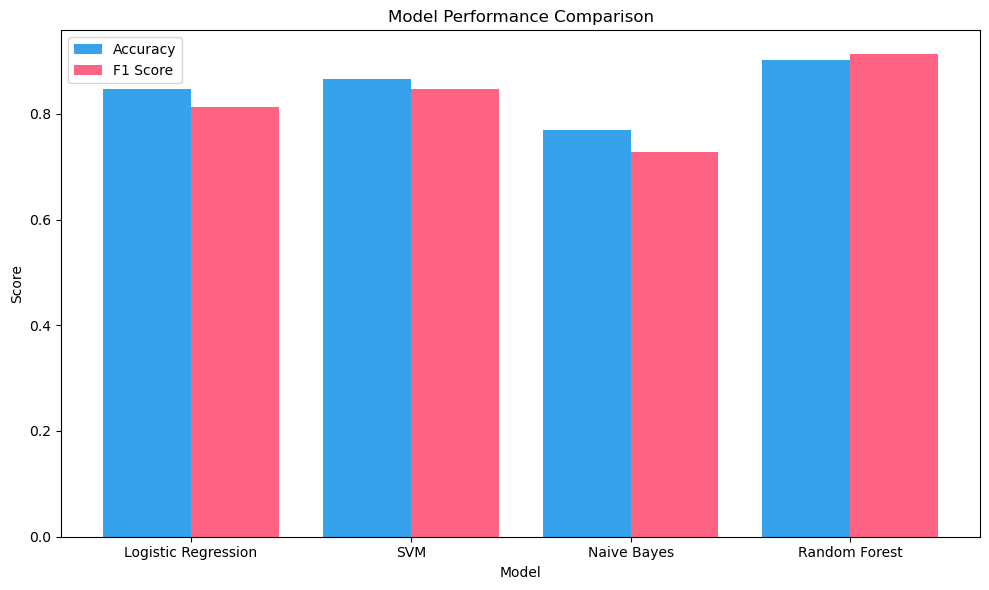

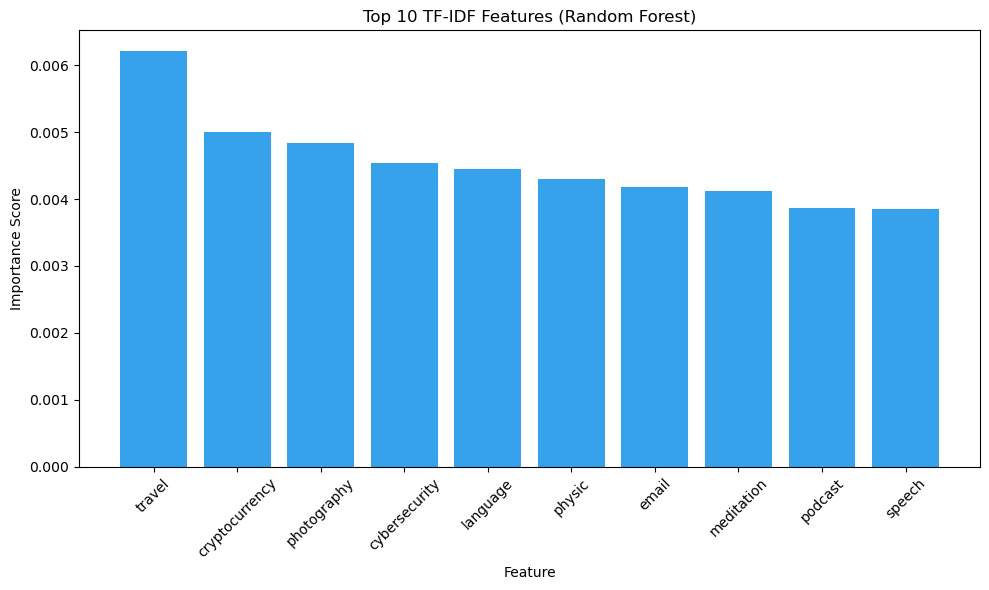

In [16]:
# Visualization 2: Model Performance Comparison
plt.figure(figsize=(10, 6))
x = range(len(model_metrics["Model"]))
plt.bar([i - 0.2 for i in x], model_metrics["Accuracy"], width=0.4, label="Accuracy", color="#36A2EB")
plt.bar([i + 0.2 for i in x], model_metrics["F1 Score"], width=0.4, label="F1 Score", color="#FF6384")
plt.xticks(x, model_metrics["Model"])
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 3: Feature Importance (Random Forest)
rf_model = cluster_models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()
top_indices = importances.argsort()[-10:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances, color="#36A2EB")
plt.title("Top 10 TF-IDF Features (Random Forest)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


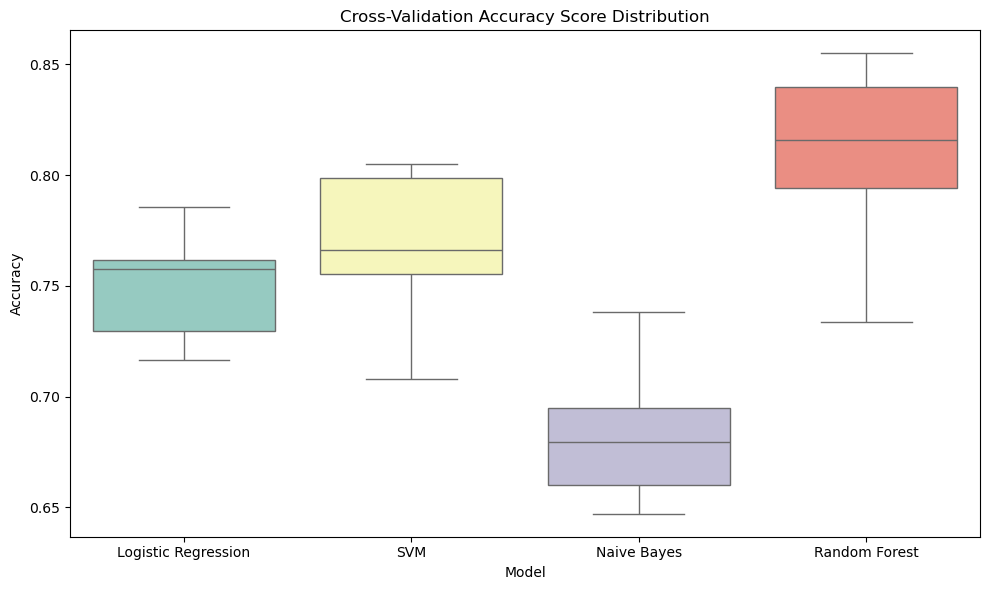

In [17]:
# Visualization 5: Cross-Validation Score Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="CV Scores", data=pd.DataFrame(cv_scores), palette="Set3")
plt.title("Cross-Validation Accuracy Score Distribution")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

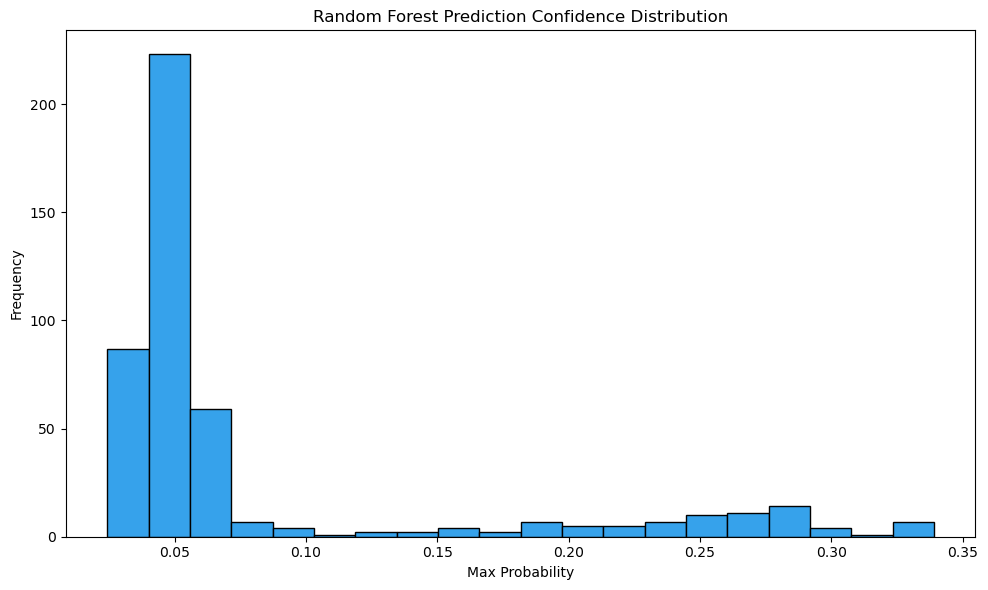

In [18]:
# Visualization 8: Prediction Confidence Histogram (SVM)
plt.figure(figsize=(10, 6))
max_probs = np.max(svm_probabilities, axis=1)
plt.hist(max_probs, bins=20, color="#36A2EB", edgecolor="black")
plt.title("Random Forest Prediction Confidence Distribution")
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

###  - Evaluating the models

In [19]:
cluster_LR = joblib.load("cluster_LR_model.pkl")

In [20]:
def predict_cluster_and_subclass(new_prompt):

    processed_prompt = preprocess_text(new_prompt)
    X_new = vectorizer.transform([processed_prompt])

    predicted_cluster = cluster_LR.predict(X_new)

    # Convert the predicted cluster from its numerical label back to the original string label
    predicted_cluster_label = le_cluster.inverse_transform(predicted_cluster)

    return predicted_cluster_label[0]

In [21]:
predict_cluster_and_subclass("How to use OpenAI's API within Streamlit?")

'API Integration'

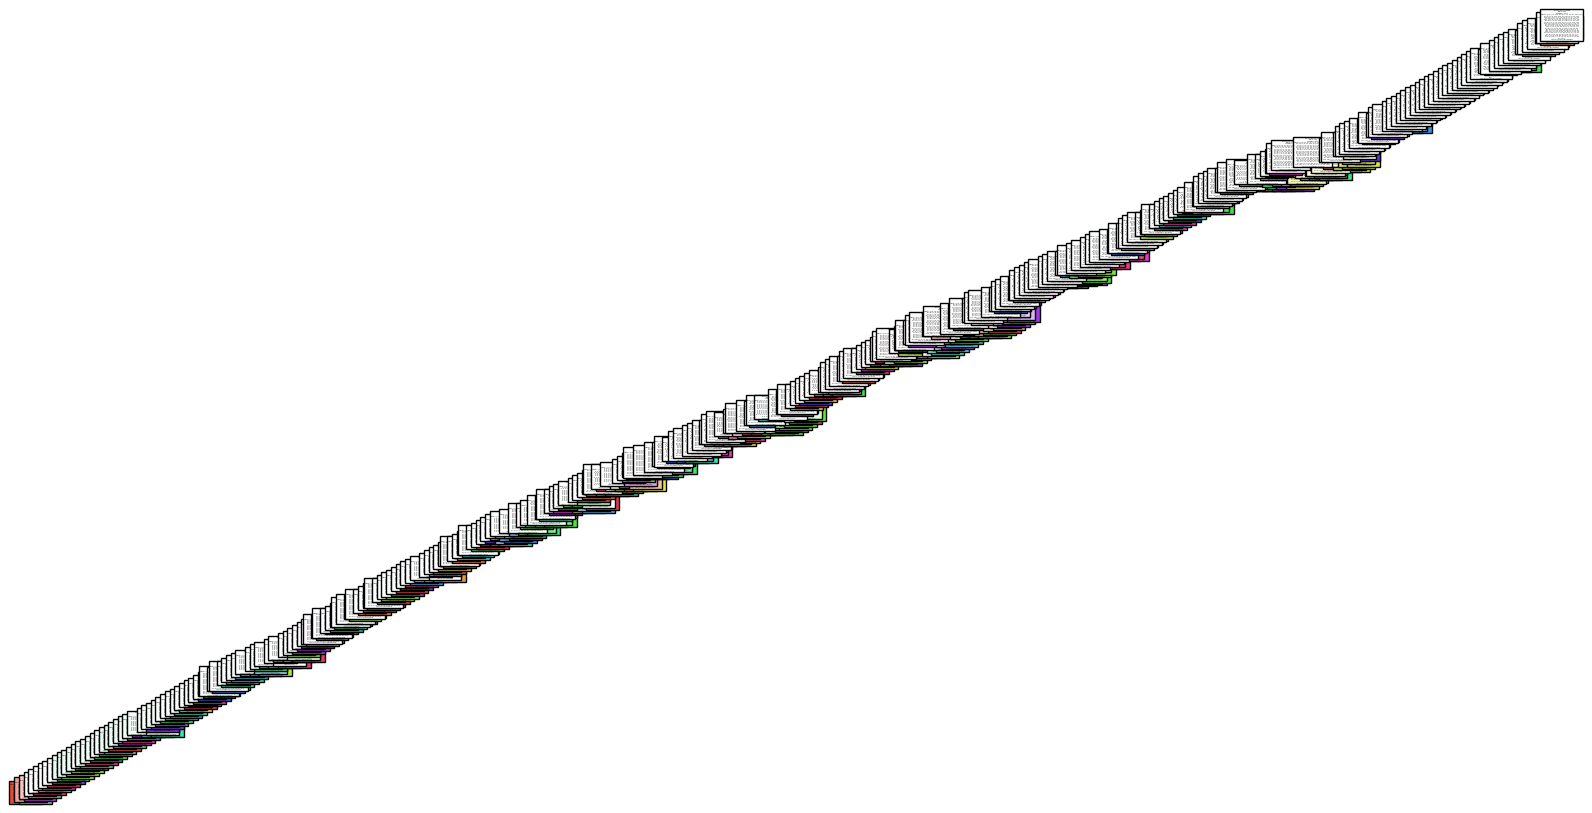

In [34]:
feature_names = [f"Feature {i}" for i in range(X.shape[1])]

# Plot the first decision tree from the Random Forest
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0], 
          feature_names=feature_names, 
          class_names=Y.unique().astype(str).tolist(), 
          filled=True)
plt.show()